In [57]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Classification of 'spam' dataset using mlr package in R


## Introducion and descriptive statistics
Both dataset and dataset description are available [here](https://archive.ics.uci.edu/ml/datasets/spambase)

In [123]:
library(ElemStatLearn)
library(mlr)
library(corrgram)
library(ggplot2)
library(xgboost)
library(xtable)
data('spam')
dim(spam)

[1] 4601   58

In [26]:
head(spam)

A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,A.10,⋯,A.49,A.50,A.51,A.52,A.53,A.54,A.55,A.56,A.57,spam
0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,spam
0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,⋯,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,spam
0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,⋯,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,spam
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,spam
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,spam
0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,⋯,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,spam


We check if data is loaded correctly and if there are any missing values:

In [ ]:
sapply(spam,class)
sum(is.na(spam))

Let's take a look at basic statistics:

In [ ]:
summary(spam)

In [25]:
corrgram(spam[,1:24], order=FALSE, lower.panel=panel.shade,
         upper.panel=panel.pie, text.panel=panel.txt)

corrgram(X[,25:48], order=FALSE, lower.panel=panel.shade,
         upper.panel=panel.pie, text.panel=panel.txt)

corrgram(X[,49:54], order=FALSE, lower.panel=panel.shade,
         upper.panel=panel.pie, text.panel=panel.txt)

corrgram(X[,55:57], order=FALSE, lower.panel=panel.shade,
         upper.panel=panel.pie, text.panel=panel.txt)


ERROR: Error in corrgram(X[, 1:24], order = FALSE, lower.panel = panel.shade, : could not find function "corrgram"


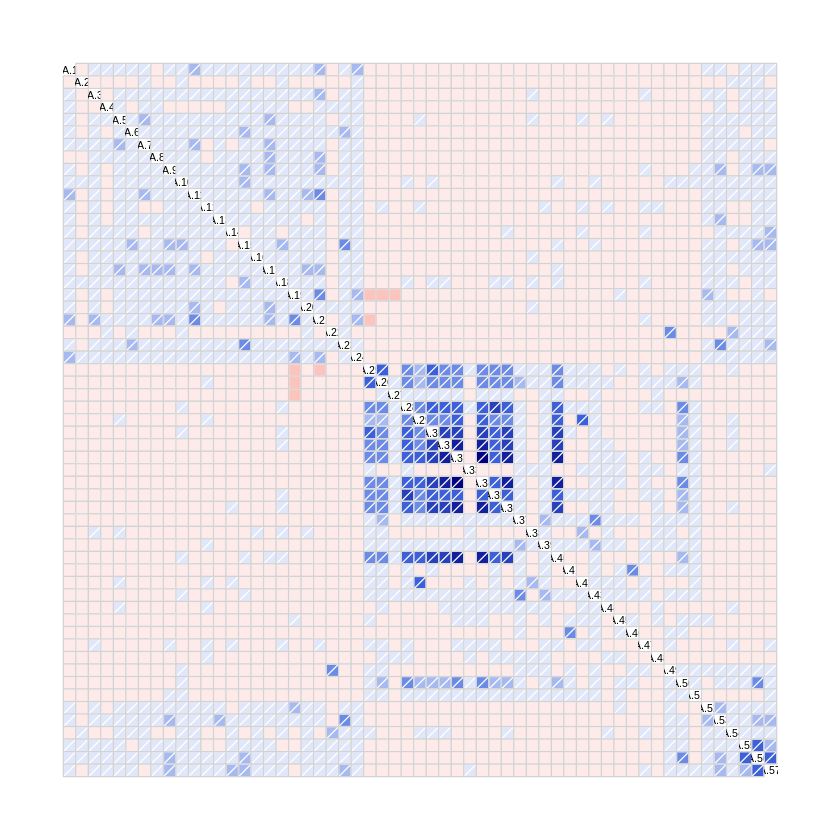

In [29]:
corrgram(spam)

We also need to check proportions of 'spam' and 'mail':

In [51]:
tab<-table(spam[,dim(spam)[2]])
prop.table(tab)


    email      spam 
0.6059552 0.3940448 

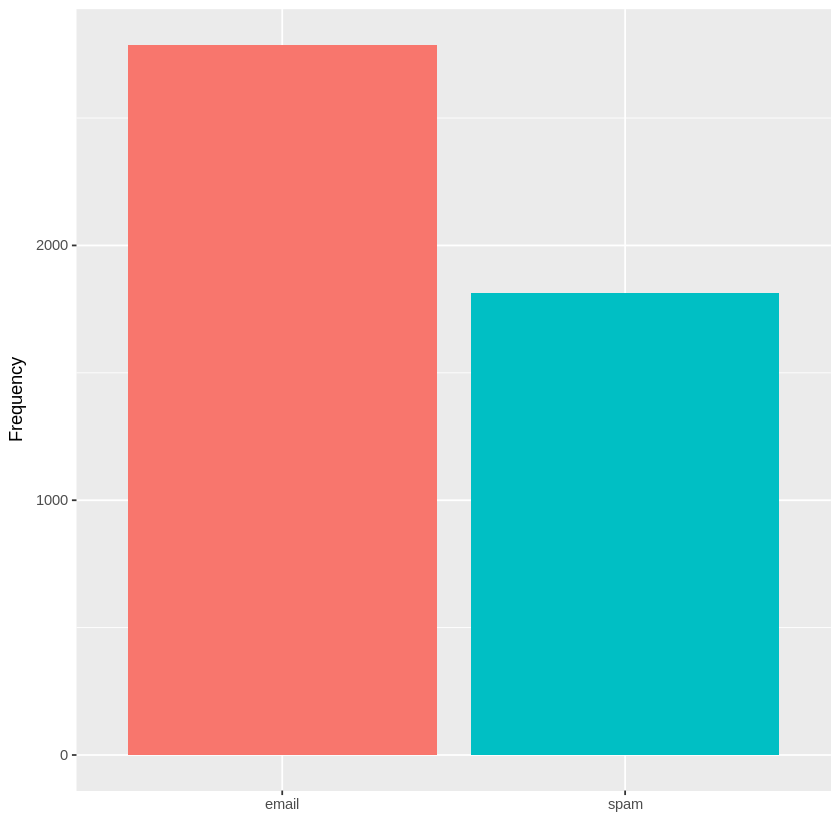

In [52]:
tab<-as.data.frame(tab)
colnames(tab)<-c('type','freq')
ggplot(tab, aes(x = as.factor(type), y=freq, fill=as.factor(type)))+geom_bar(stat="identity")+labs(x="", y='Frequency')+theme(legend.position = "none")

So we have approximately 60% of true emails and 40% of spam. We give back names to our features to see which words occur most frequent.

In [54]:
spamColNames <- c("word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", 
    "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet", 
    "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will", 
    "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free", 
    "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit", 
    "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", 
    "word_freq_hp", "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", 
    "word_freq_labs", "word_freq_telnet", "word_freq_857", "word_freq_data", 
    "word_freq_415", "word_freq_85", "word_freq_technology", "word_freq_1999", 
    "word_freq_parts", "word_freq_pm", "word_freq_direct", "word_freq_cs", "word_freq_meeting", 
    "word_freq_original", "word_freq_project", "word_freq_re", "word_freq_edu", 
    "word_freq_table", "word_freq_conference", "char_freq_ch;", "char_freq_ch(", 
    "char_freq_ch[", "char_freq_ch!", "char_freq_ch$", "char_freq_ch#", "capital_run_length_average", 
    "capital_run_length_longest", "capital_run_length_total", "spam")
colnames(spam)<-spamColNames

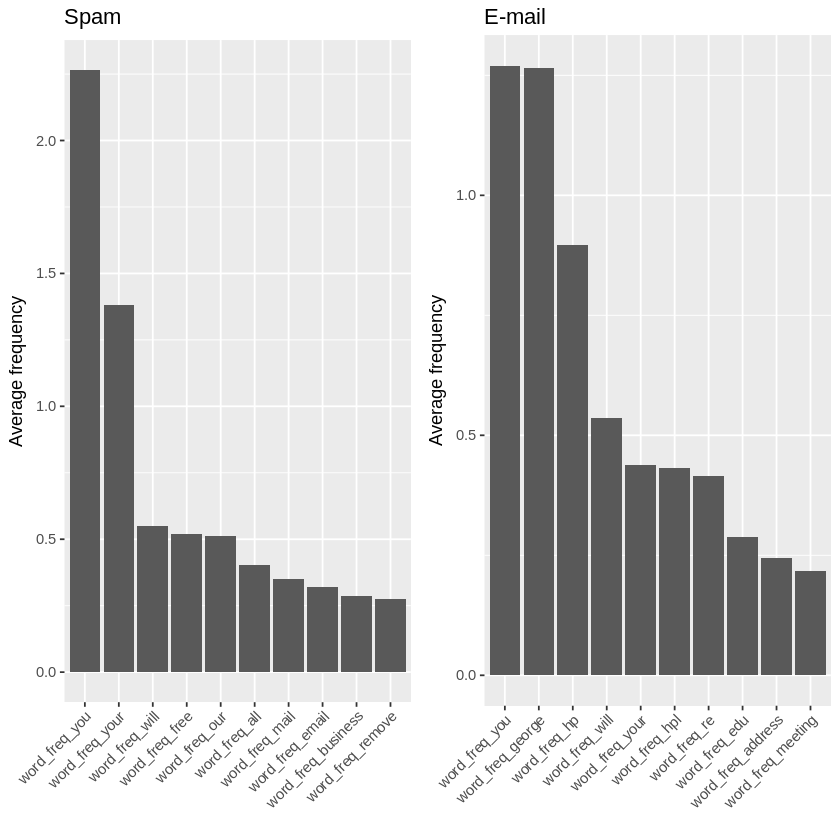

In [61]:
n_most_frequent<-10
spam.words<-spam[spam[,dim(spam)[2]]=='spam',1:48]
email.words<-spam[spam[,dim(spam)[2]]=='email',1:48]
avg.spam<-sort(sapply(spam.words,mean), decreasing = TRUE)
avg.spam<-as.data.frame(avg.spam[1:n_most_frequent])
avg.email<-sort(sapply(email.words,mean), decreasing = TRUE)
avg.email<-as.data.frame(avg.email[1:n_most_frequent])
colnames(avg.spam)<-'avg_word_freq'
colnames(avg.email)<-'avg_word_freq'
w1_spam <- ggplot(avg.spam, aes(x=reorder(rownames(avg.spam),-avg_word_freq),y=avg_word_freq))+geom_bar(stat = "identity")+ theme(axis.text.x = element_text(angle = 45, hjust = 1)) +ggtitle("Spam")+ labs(x='',y='Average word frequency')
w2_email <- ggplot(avg.email, aes(x=reorder(rownames(avg.email),-avg_word_freq),y=avg_word_freq))+geom_bar(stat = "identity")+ theme(axis.text.x = element_text(angle = 45, hjust = 1)) +ggtitle("E-mail")+ labs(x='',y='Average word frequency')
multiplot(w1_spam, w2_email, cols=2)

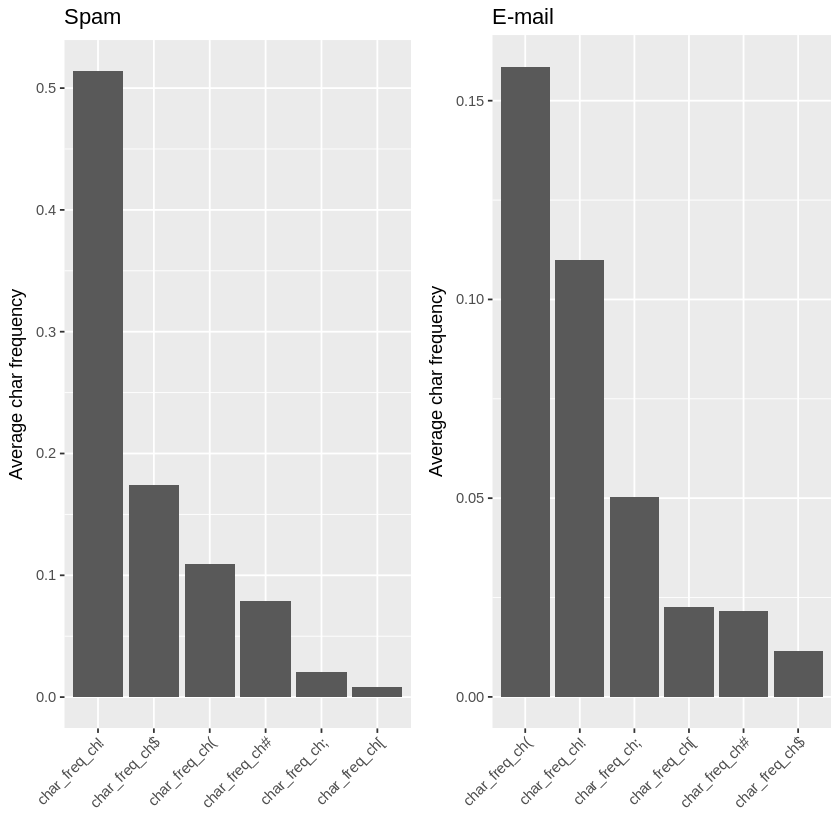

In [67]:
spam.chars<-spam[spam[,dim(spam)[2]]=='spam',49:54]
email.chars<-spam[spam[,dim(spam)[2]]=='email',49:54]
avg.spam.chars <- sort(sapply(spam.chars, mean),decreasing = TRUE)
avg.email.chars <- sort(sapply(email.chars, mean),decreasing = TRUE)
avg.spam.chars<-as.data.frame(avg.spam.chars)
avg.email.chars<-as.data.frame(avg.email.chars)
colnames(avg.spam.chars) <- 'avg_char_freq'
colnames(avg.email.chars) <- 'avg_char_freq'

char_spam <- ggplot(avg.spam.chars, aes(x=reorder(rownames(avg.spam.chars),-avg_char_freq),y=avg_char_freq))+geom_bar(stat = "identity")+ theme(axis.text.x = element_text(angle = 45, hjust = 1)) +ggtitle("Spam")+ labs(x='',y='Average char frequency')
char_email <- ggplot(avg.email.chars, aes(x=reorder(rownames(avg.email.chars),-avg_char_freq),y=avg_char_freq))+geom_bar(stat = "identity")+ theme(axis.text.x = element_text(angle = 45, hjust = 1)) +ggtitle("E-mail")+ labs(x='',y='Average char frequency')
multiplot(char_spam, char_email, cols=2)


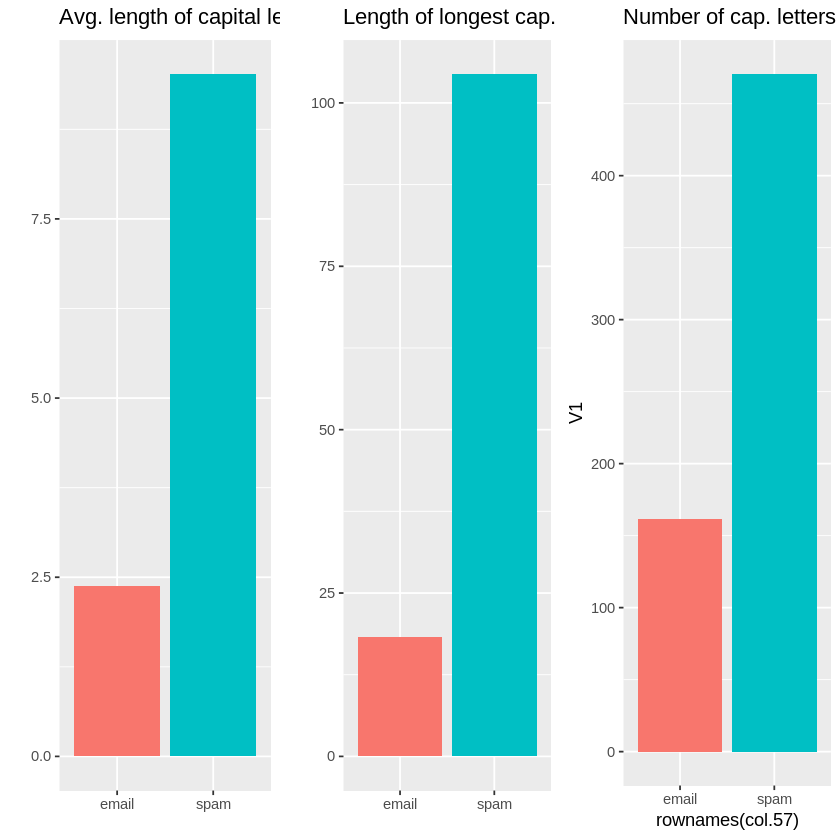

In [70]:
par(mfrow=c(1,3))
col.55<-as.data.frame(as.matrix(by(spam[,55],spam[,dim(spam)[2]],mean)))
col.56<-as.data.frame(as.matrix(by(spam[,56],spam[,dim(spam)[2]],mean)))
col.57<-as.data.frame(as.matrix(by(spam[,57],spam[,dim(spam)[2]],mean)))
w1<-ggplot(col.55, aes(x=rownames(col.55),y=V1,fill=rownames(col.55)))+geom_bar(stat='identity') + theme(legend.position="none") + ggtitle("Avg. length of capital letters sequence")+labs(x='',y='')
w2<-ggplot(col.56, aes(x=rownames(col.56),y=V1,fill=rownames(col.56)))+geom_bar(stat='identity') + theme(legend.position="none") + ggtitle("Length of longest cap. letters sequence")+labs(x='',y='')
w3<-ggplot(col.57, aes(x=rownames(col.57),y=V1,fill=rownames(col.57)))+geom_bar(stat='identity') + theme(legend.position="none") + ggtitle("Number of cap. letters")
multiplot(w1,w2,w3, cols=3)

Lastly let's take a look at distributions of our features. It's typical that our data has atoms in 0.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


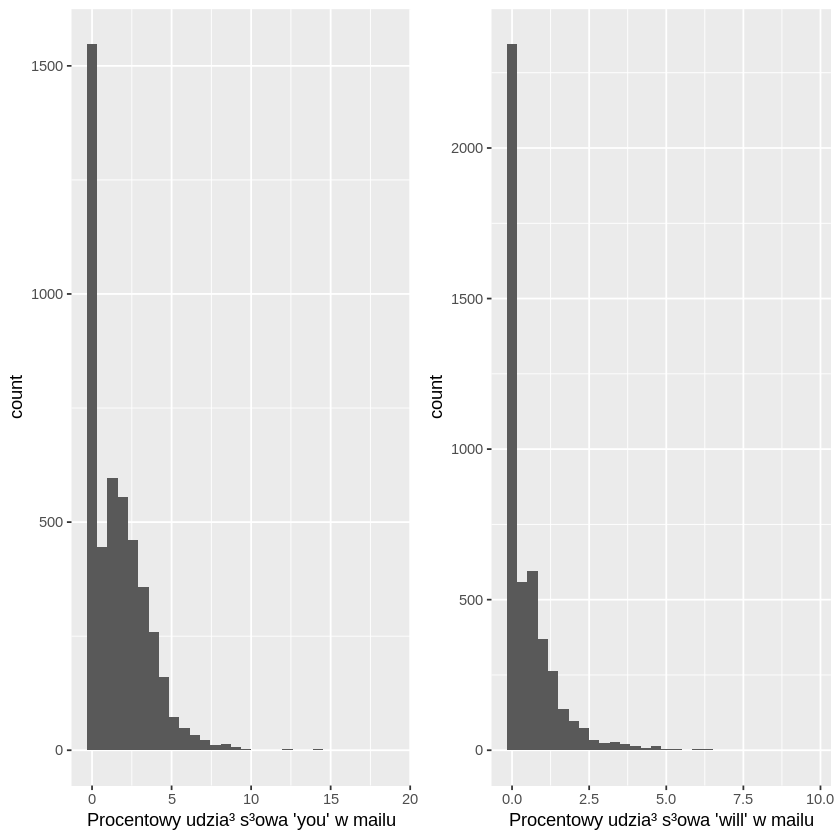

In [71]:
q1<-qplot(spam$word_freq_you, geom="histogram") +xlab("Procentowy udzia³ s³owa 'you' w mailu")
q2<-qplot(spam$word_freq_will, geom="histogram")+xlab("Procentowy udzia³ s³owa 'will' w mailu")
multiplot( q1,q2, cols=2)

Some methods of classification (for example LDA) assumes normality of data. As we can see the sample distributions above is heavy-tailed, so we transform our data logarithmically (acctualy log(x+0.1) becouse of zeros).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


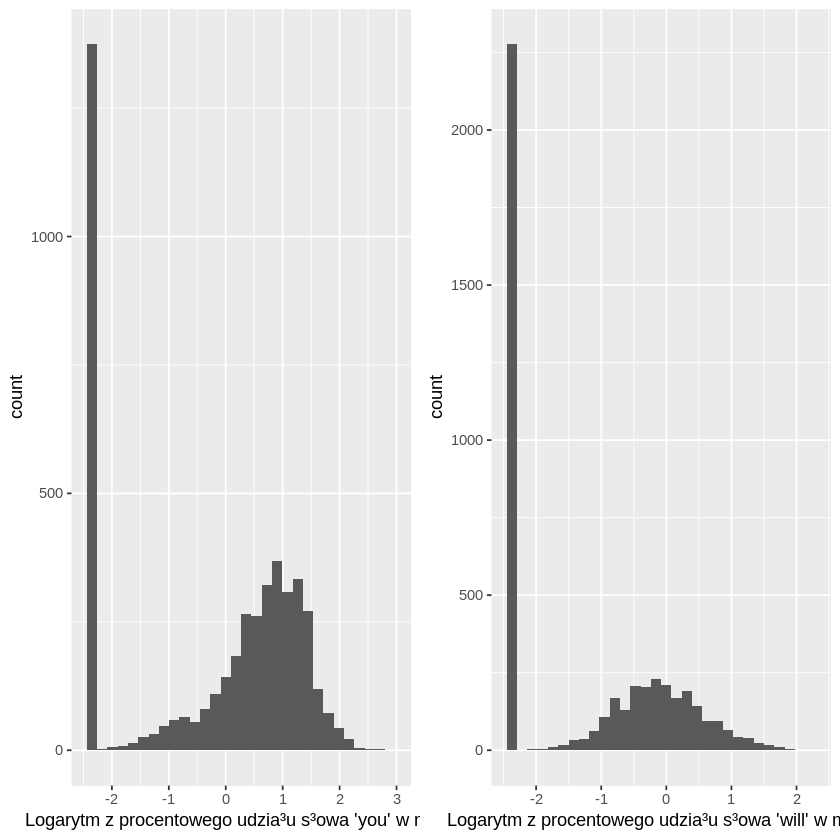

In [72]:
q1<-qplot(log(spam$word_freq_you+0.1), geom="histogram") +xlab("Logarytm z procentowego udzia³u s³owa 'you' w mailu")
q2<-qplot(log(spam$word_freq_will+0.1), geom="histogram")+xlab("Logarytm z procentowego udzia³u s³owa 'will' w mailu")
multiplot( q1,q2, cols=2)

## Classification
For Logistic Regression and LDA method we transform data logarithmically. We start by making mlr task. For some of methods we tune hyperparameters by RandomSearch or GridSearch algorithm. For all methods we calculate efficiency using accuracy and AUC. We will compare all methods at the end of this chapter.

In [80]:
data('spam')
spam.log<-spam
spam.log[,-dim(spam)[2]]<-log(spam[,-dim(spam)[2]]+0.1)

In [82]:
task<-makeClassifTask(data = spam, target = 'spam')
task.log<-makeClassifTask(data = spam.log, target = 'spam')


### Logistic Regression

In [83]:
logistic.learner <- makeLearner("classif.logreg",predict.type = "prob")
cv.logistic <- crossval(learner = logistic.learner, task = task.log, iters = 5,
                        stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

acc.test.mean auc.test.mean 
    0.9413213     0.9822801

### LDA

In [84]:
lda.learner <- makeLearner("classif.lda",predict.type = "prob")
cv.lda <- crossval(learner = lda.learner, task = task.log, iters = 5, 
                   stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### Naive Bayes Classificator

In [119]:
bayes.learner <- makeLearner("classif.naiveBayes", predict.type = 'prob')
cv.bayes <- crossval(learner = bayes.learner, task = task, iters = 5,
                     stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### k-Nearest Neighbours
We tune number of neighbours with GridSearch. 

In [85]:
#search through paramset
knn_params <- makeParamSet(
  makeDiscreteParam("k", values = c(1,2,3,4,5,6,7,8,9,10))
)
ctrl = makeTuneControlGrid()
rdesc = makeResampleDesc("CV", iters = 3L)
tuned_params = tuneParams("classif.kknn", task = task, resampling = rdesc, par.set = knn_params, control = ctrl)
knn.learner <- makeLearner("classif.kknn", predict.type = 'prob', par.vals = tuned_params$x)
cv.knn <- crossval(learner = knn.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

Loading required package: kknn
[Tune] Started tuning learner classif.kknn for parameter set:
      Type len Def               Constr Req Tunable Trafo
k discrete   -   - 1,2,3,4,5,6,7,8,9,10   -    TRUE     -
With control class: TuneControlGrid
Imputation value: 1
[Tune-x] 1: k=1
[Tune-y] 1: mmce.test.mean=0.0975911; time: 0.0 min
[Tune-x] 2: k=2
[Tune-y] 2: mmce.test.mean=0.0975911; time: 0.0 min
[Tune-x] 3: k=3
[Tune-y] 3: mmce.test.mean=0.0975911; time: 0.0 min
[Tune-x] 4: k=4
[Tune-y] 4: mmce.test.mean=0.0975911; time: 0.0 min
[Tune-x] 5: k=5
[Tune-y] 5: mmce.test.mean=0.0975911; time: 0.0 min
[Tune-x] 6: k=6
[Tune-y] 6: mmce.test.mean=0.0871579; time: 0.0 min
[Tune-x] 7: k=7
[Tune-y] 7: mmce.test.mean=0.0858535; time: 0.0 min
[Tune-x] 8: k=8
[Tune-y] 8: mmce.test.mean=0.0852012; time: 0.0 min
[Tune-x] 9: k=9
[Tune-y] 9: mmce.test.mean=0.0847665; time: 0.0 min
[Tune-x] 10: k=10
[Tune-y] 10: mmce.test.mean=0.0858531; time: 0.0 min
[Tune] Result: k=9 : mmce.test.mean=0.0847665


### Random Forest

In [86]:
randForest_params <- makeParamSet(
  makeIntegerParam("ntree", lower = 100, upper = 500),
  makeIntegerParam("mtry", lower = 1, upper = 10),
  makeIntegerParam("maxnodes", lower = 5, upper = 50),
  makeIntegerParam("nodesize", lower = 1, upper = 15)
)
ctrl = makeTuneControlRandom(maxit = 20)
rdesc = makeResampleDesc("CV", iters = 3L)
tuned_params = tuneParams("classif.randomForest", task = task, resampling = rdesc, par.set = randForest_params, control = ctrl)
randForest.learner <- makeLearner("classif.randomForest", predict.type = 'prob', par.vals = tuned_params$x)
cv.randForest <- crossval(learner = randForest.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

[Tune] Started tuning learner classif.randomForest for parameter set:
            Type len Def     Constr Req Tunable Trafo
ntree    integer   -   - 100 to 500   -    TRUE     -
mtry     integer   -   -    1 to 10   -    TRUE     -
maxnodes integer   -   -    5 to 50   -    TRUE     -
nodesize integer   -   -    1 to 15   -    TRUE     -
With control class: TuneControlRandom
Imputation value: 1
[Tune-x] 1: ntree=422; mtry=5; maxnodes=50; nodesize=6
[Tune-y] 1: mmce.test.mean=0.0680285; time: 0.3 min
[Tune-x] 2: ntree=287; mtry=4; maxnodes=32; nodesize=2
[Tune-y] 2: mmce.test.mean=0.0758522; time: 0.2 min
[Tune-x] 3: ntree=124; mtry=1; maxnodes=18; nodesize=14
[Tune-y] 3: mmce.test.mean=0.1399723; time: 0.1 min
[Tune-x] 4: ntree=206; mtry=8; maxnodes=50; nodesize=1
[Tune-y] 4: mmce.test.mean=0.0652032; time: 0.2 min
[Tune-x] 5: ntree=122; mtry=1; maxnodes=35; nodesize=4
[Tune-y] 5: mmce.test.mean=0.1154096; time: 0.1 min
[Tune-x] 6: ntree=292; mtry=8; maxnodes=14; nodesize=14
[Tune-y] 6

### Support Vector Machine

In [89]:
svm_params <- makeParamSet(
  makeNumericParam("C", lower = -1, upper = 10, trafo = function(x) 2^x),
  makeNumericParam("epsilon", lower = -1, upper = 10, trafo = function(x) 2^x)
)
ctrl = makeTuneControlRandom(maxit = 20)
rdesc = makeResampleDesc("CV", iters = 3L)
tuned_params = tuneParams("classif.ksvm", task = task, resampling = rdesc, par.set = svm_params, control = ctrl)
svm.learner <- makeLearner("classif.ksvm", predict.type = 'prob', par.vals = tuned_params$x)
cv.svm <- crossval(learner = svm.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)


[Tune] Started tuning learner classif.ksvm for parameter set:
           Type len Def   Constr Req Tunable Trafo
C       numeric   -   - -1 to 10   -    TRUE     Y
epsilon numeric   -   - -1 to 10   -    TRUE     Y
With control class: TuneControlRandom
Imputation value: 1
[Tune-x] 1: C=14; epsilon=3.33
[Tune-y] 1: mmce.test.mean=0.0723753; time: 0.1 min
[Tune-x] 2: C=3.6; epsilon=24
[Tune-y] 2: mmce.test.mean=0.0719407; time: 0.1 min
[Tune-x] 3: C=8.7; epsilon=598
[Tune-y] 3: mmce.test.mean=0.0734621; time: 0.1 min
[Tune-x] 4: C=22.1; epsilon=83.8
[Tune-y] 4: mmce.test.mean=0.0741142; time: 0.1 min
[Tune-x] 5: C=1.24; epsilon=746
[Tune-y] 5: mmce.test.mean=0.0723756; time: 0.1 min
[Tune-x] 6: C=344; epsilon=942
[Tune-y] 6: mmce.test.mean=0.0862858; time: 0.1 min
[Tune-x] 7: C=835; epsilon=996
[Tune-y] 7: mmce.test.mean=0.0891124; time: 0.1 min
[Tune-x] 8: C=1.03; epsilon=1.09
[Tune-y] 8: mmce.test.mean=0.0699852; time: 0.1 min
[Tune-x] 9: C=1.21; epsilon=176
[Tune-y] 9: mmce.test.mean=

### XGBoost

In [97]:
xgb_params <- makeParamSet(
  makeIntegerParam("nrounds", lower = 100, upper = 500),
  makeIntegerParam("max_depth", lower = 1, upper = 10),
  makeNumericParam("eta", lower = .1, upper = .5),
  makeNumericParam("lambda", lower = -1, upper = 0, trafo = function(x) 10^x)
)
control <- makeTuneControlRandom(maxit = 20)
resample_desc <- makeResampleDesc("CV", iters = 3)
tuned_params <- tuneParams('classif.xgboost', task = task,resampling = resample_desc,par.set = xgb_params, control = control)
xgboost.learner <- makeLearner("classif.xgboost", predict.type = 'prob', par.vals = tuned_params$x)
cv.xgboost <- crossval(learner = xgboost.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

[Tune] Started tuning learner classif.xgboost for parameter set:
             Type len Def     Constr Req Tunable Trafo
nrounds   integer   -   - 100 to 500   -    TRUE     -
max_depth integer   -   -    1 to 10   -    TRUE     -
eta       numeric   -   - 0.1 to 0.5   -    TRUE     -
lambda    numeric   -   -    -1 to 0   -    TRUE     Y
With control class: TuneControlRandom
Imputation value: 1
[Tune-x] 1: nrounds=114; max_depth=2; eta=0.329; lambda=0.565
[Tune-y] 1: mmce.test.mean=0.0486857; time: 0.0 min
[Tune-x] 2: nrounds=267; max_depth=3; eta=0.385; lambda=0.701
[Tune-y] 2: mmce.test.mean=0.0491197; time: 0.1 min
[Tune-x] 3: nrounds=332; max_depth=5; eta=0.156; lambda=0.35
[Tune-y] 3: mmce.test.mean=0.0465110; time: 0.2 min
[Tune-x] 4: nrounds=114; max_depth=9; eta=0.32; lambda=0.157
[Tune-y] 4: mmce.test.mean=0.0499892; time: 0.1 min
[Tune-x] 5: nrounds=320; max_depth=1; eta=0.123; lambda=0.993
[Tune-y] 5: mmce.test.mean=0.0543364; time: 0.1 min
[Tune-x] 6: nrounds=212; max_depth

### Neural Nets

In [117]:
nn_params <- makeParamSet(
  makeIntegerParam("size", lower = 5, upper = 10),
  makeNumericParam("decay", lower=0,upper=5)
)
control <- makeTuneControlRandom(maxit = 20)
resample_desc <- makeResampleDesc("CV", iters = 3)
nn_learner <- makeLearner("classif.nnet", predict.type = 'prob', trace=FALSE)
tuned_params <- tuneParams(nn_learner, task = task,resampling = resample_desc,par.set = nn_params, control = control)
nn_learner <- makeLearner("classif.nnet", predict.type = 'prob', par.vals = tuned_params$x)
nn_learner<-setHyperPars(nn_learner,trace=FALSE)
cv.nn <- crossval(learner = nn_learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)


[Tune] Started tuning learner classif.nnet for parameter set:
         Type len Def  Constr Req Tunable Trafo
size  integer   -   - 5 to 10   -    TRUE     -
decay numeric   -   -  0 to 5   -    TRUE     -
With control class: TuneControlRandom
Imputation value: 1
[Tune-x] 1: size=8; decay=1.25
[Tune-y] 1: mmce.test.mean=0.0591179; time: 0.1 min
[Tune-x] 2: size=8; decay=0.0112
[Tune-y] 2: mmce.test.mean=0.0619441; time: 0.1 min
[Tune-x] 3: size=9; decay=0.74
[Tune-y] 3: mmce.test.mean=0.0582476; time: 0.2 min
[Tune-x] 4: size=9; decay=0.531
[Tune-y] 4: mmce.test.mean=0.0578134; time: 0.2 min
[Tune-x] 5: size=6; decay=1.97
[Tune-y] 5: mmce.test.mean=0.0593351; time: 0.1 min
[Tune-x] 6: size=8; decay=2.32
[Tune-y] 6: mmce.test.mean=0.0619445; time: 0.2 min
[Tune-x] 7: size=6; decay=3.02
[Tune-y] 7: mmce.test.mean=0.0628127; time: 0.1 min
[Tune-x] 8: size=9; decay=2.15
[Tune-y] 8: mmce.test.mean=0.0621611; time: 0.2 min
[Tune-x] 9: size=8; decay=1.45
[Tune-y] 9: mmce.test.mean=0.0610760; 

### Comparision

In [125]:
results<-rbind(cv.logistic$aggr,cv.lda$aggr,cv.bayes$aggr,cv.knn$aggr,cv.randForest$aggr,cv.svm$aggr,cv.xgboost$aggr,cv.nn$aggr)
results<-as.data.frame(results)
rownames(results)<-c('Logistic Regression','LDA','Naive Bayes','kNN','Random Forests','SVM','XGBoost','Neural nets')
colnames(results)<-c('Accuracy','AUC')
results

,Accuracy,AUC,NA,NA
Logistic Regression,0.9413213,0.9822801,0.9413213,0.9822801
LDA,0.9350153,0.9782911,0.9659241,0.8874892
Naive Bayes,0.7126703,0.8941299,0.5595439,0.9481607
kNN,0.9141498,0.9649274,0.9390237,0.8759022
Random Forests,0.9352304,0.9738861,0.9698706,0.8819536
SVM,0.9334886,0.9739242,0.9562396,0.8985100
XGBoost,0.9530571,0.9871615,0.9641339,0.9360197
Neural nets,0.9428374,0.9817524,0.9522944,0.9282849


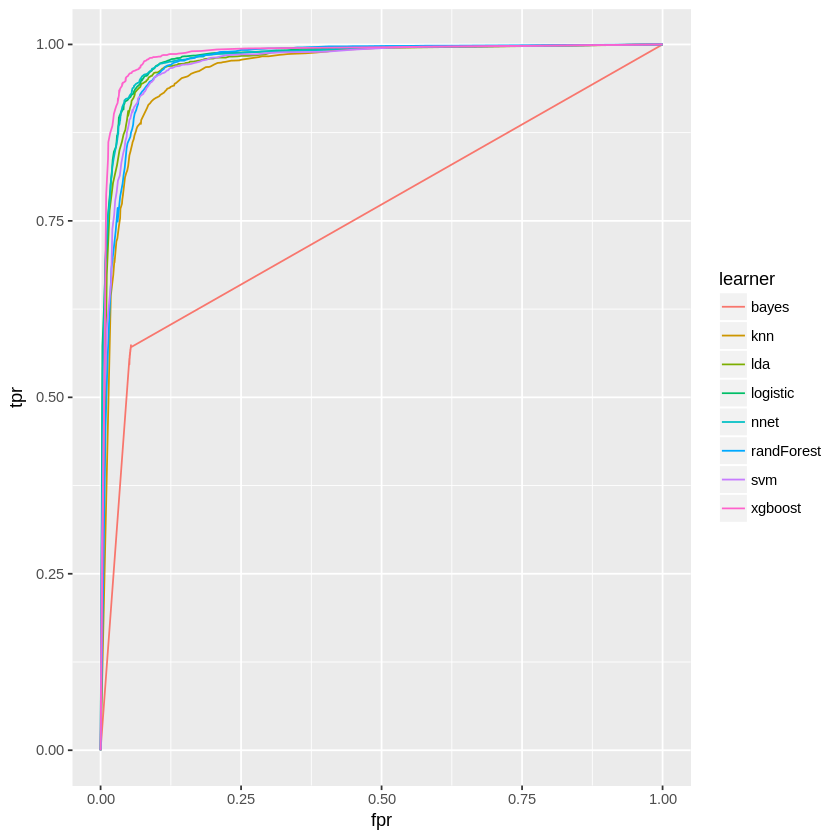

In [126]:
pred.logistic<-getRRPredictions(cv.logistic)
pred.lda<-getRRPredictions(cv.lda)
pred.bayes<-getRRPredictions(cv.bayes)
pred.knn<-getRRPredictions(cv.knn)
pred.randForest<-getRRPredictions(cv.randForest)
pred.svm<-getRRPredictions(cv.svm)
pred.xgboost<-getRRPredictions(cv.xgboost)
pred.nn<-getRRPredictions(cv.nn)
df = generateThreshVsPerfData(list(lda = pred.lda, logistic=pred.logistic, bayes=pred.bayes,knn=pred.knn,randForest=pred.randForest,svm = pred.svm, xgboost = pred.xgboost, nnet = pred.nn), measures = list(fpr, tpr))
ggplot(as.data.frame(df$data),aes(x=fpr,y=tpr, col=learner))+geom_line()

## Classification with dimension reduction
We reduct dimensions with PCA algorithm in order to see how data reduction influence classification efficiency

### PCA

In [142]:
spam.pca <- prcomp(spam[,-dim(spam)[2]], retx = T, center=T, scale. =T)

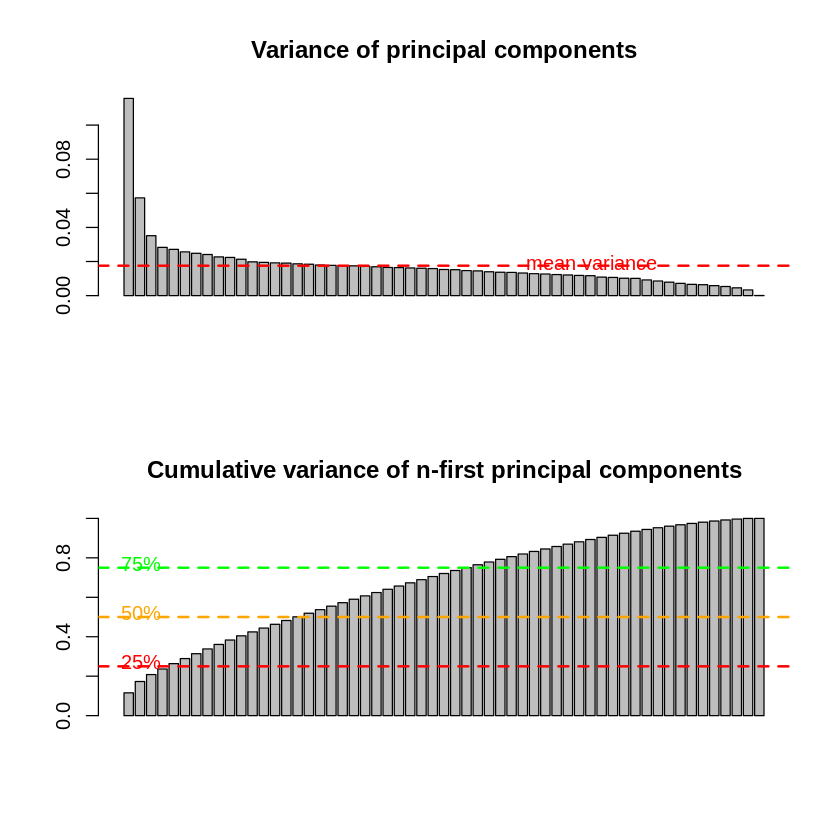

In [135]:
par(mfrow=c(2,1))
variance <- (spam.pca$sdev^2)/sum(spam.pca$sdev^2) 
barplot(variance, main = 'Variance of principal components')
avg_var<-mean(variance)
abline(a=avg_var, b=0, col="red", lwd=2, lty=2)
text(x=50, y=avg_var+0.002, label = "mean variance", col="red")
cum_variance<-cumsum(variance)
barplot(cum_variance, main='Cumulative variance of n-first principal components')
abline(a=0.25, b=0, col="red", lwd=2, lty=2)
text(x=2, y=0.27, label = "25%", col="red")
abline(a=0.5, b=0, col="orange", lwd=2, lty=2)
text(x=2, y=0.52, label = "50%", col="orange")
abline(a=0.75, b=0, col="green", lwd=2, lty=2)
text(x=2, y=0.77, label = "75%", col="green")

There are many possibilities to choose number of features. Of course the more features we take the better efficiency we get. In order to make significant reduction we choose components that has cumulative variance over 90%.

In [138]:
sum(cum_variance>0.90)

[1] 15

In [143]:
n<-15
spam.pca<-spam.pca$x[,1:n]
spam.pca<-cbind(spam.pca,spam$spam)
spam.pca<-as.data.frame(spam.pca)
colnames(spam.pca)[dim(spam.pca)[2]]<-'spam'
spam.pca$spam<-as.factor(spam.pca$spam)
levels(spam.pca$spam)<-c('email','spam')

Now, when the data is prepared, we can make mlr task and start classification.

In [ ]:
task<-makeClassifTask(data=train, target = "spam")

### Logistic Regression

In [ ]:
logistic.learner <- makeLearner("classif.logreg",predict.type = "prob")
cv.logistic <- crossval(learner = logistic.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### LDA

In [ ]:
lda.learner <- makeLearner("classif.lda",predict.type = "prob")
cv.lda <- crossval(learner = lda.learner, task = task,iters = 5,stratif=TRUE,measures = list(acc,mlr::auc),show.info = F)

### Naive Bayes Classificator

In [ ]:
bayes.learner <- makeLearner("classif.naiveBayes", predict.type = 'prob')
cv.bayes <- crossval(learner = bayes.learner, task = task,iters = 5,stratif=TRUE,measures = list(acc,mlr::auc),show.info = F)

### k-Nearest Neighbours

In [ ]:
knn_params <- makeParamSet(
  makeDiscreteParam("k", values = c(1,2,3,4,5,6,7,8,9,10))
)
ctrl = makeTuneControlGrid()
rdesc = makeResampleDesc("CV", iters = 3L)
tuned_params = tuneParams("classif.kknn", task = task, resampling = rdesc, par.set = knn_params, control = ctrl)
knn.learner <- makeLearner("classif.kknn", predict.type = 'prob', par.vals = tuned_params$x)
cv.knn <- crossval(learner = knn.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### Random Forest

In [ ]:
randForest_params <- makeParamSet(
  makeIntegerParam("ntree", lower = 100, upper = 500),
  makeIntegerParam("mtry", lower = 1, upper = 10),
  makeIntegerParam("maxnodes", lower = 5, upper = 50),
  makeIntegerParam("nodesize", lower = 1, upper = 15)
)
ctrl = makeTuneControlRandom(maxit = 10)
rdesc = makeResampleDesc("CV", iters = 3L)
tuned_params = tuneParams("classif.randomForest", task = task, resampling = rdesc,
  par.set = randForest_params, control = ctrl)
randForest.learner <- makeLearner("classif.randomForest", predict.type = 'prob', par.vals = tuned_params$x)
cv.randForest <- crossval(learner = randForest.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### SVM

In [ ]:
svm_params <- makeParamSet(
  makeNumericParam("C", lower = -1, upper = 10, trafo = function(x) 2^x),
  makeNumericParam("epsilon", lower = -1, upper = 10, trafo = function(x) 2^x)
)
ctrl = makeTuneControlRandom(maxit = 10)
rdesc = makeResampleDesc("CV", iters = 3L)
tuned_params = tuneParams("classif.ksvm", task = task, resampling = rdesc, par.set = svm_params, control = ctrl)
svm.learner <- setHyperPars(makeLearner("classif.ksvm", predict.type = 'prob'), par.vals = tuned_params$x)
cv.svm <- crossval(learner = svm.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### XGBoost

In [ ]:
xgb_params <- makeParamSet(
  makeIntegerParam("nrounds", lower = 100, upper = 500),
  makeIntegerParam("max_depth", lower = 1, upper = 10),
  makeNumericParam("eta", lower = .1, upper = .5),
  makeNumericParam("lambda", lower = -1, upper = 0, trafo = function(x) 10^x)
)
control <- makeTuneControlRandom(maxit = 10)
resample_desc <- makeResampleDesc("CV", iters = 5)
tuned_params <- tuneParams('classif.xgboost', task = task,resampling = resample_desc,par.set = xgb_params, control = control)
xgboost.learner <- makeLearner("classif.xgboost", predict.type = 'prob', par.vals = tuned_params$x)
cv.xgboost <- crossval(learner = xgboost.learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### Neural Nets

In [ ]:
nn_params <- makeParamSet(
  makeIntegerParam("size", lower = 5, upper = 10),
  makeNumericParam("decay", lower=0,upper=5)
)
control <- makeTuneControlRandom(maxit = 10)
resample_desc <- makeResampleDesc("CV", iters = 3)
nn_learner <- makeLearner("classif.nnet", predict.type = 'prob', trace=FALSE)
tuned_params <- tuneParams(nn_learner, task = task,resampling = resample_desc,par.set = nn_params, control = control)
nn_learner <- makeLearner("classif.nnet", predict.type = 'prob', par.vals = tuned_params$x)
nn_learner<-setHyperPars(nn_learner,trace=FALSE)
cv.nn <- crossval(learner = nn_learner, task = task, iters = 5, stratif=TRUE, measures = list(acc,mlr::auc), show.info = F)

### Comparision

In [ ]:
results<-rbind(cv.logistic$aggr,cv.lda$aggr,cv.bayes$aggr,cv.knn$aggr,cv.randForest$aggr,cv.svm$aggr,cv.xgboost$aggr, cv.nn$aggr)
results<-as.data.frame(wyniki)
rownames(results)<-c('Logistic Regression','LDA','Naive Bayes','kNN','Random Forests','SVM','XGBoost','Neural nets')
colnames(results)<-c('Accuracy','AUC')
results

In [145]:
pred.logistic<-getRRPredictions(cv.logistic)
pred.lda<-getRRPredictions(cv.lda)
pred.bayes<-getRRPredictions(cv.bayes)
pred.knn<-getRRPredictions(cv.knn)
pred.randForest<-getRRPredictions(cv.randForest)
pred.svm<-getRRPredictions(cv.svm)
pred.xgboost<-getRRPredictions(cv.xgboost)
pred.xgboost<-getRRPredictions(cv.nn)
df = generateThreshVsPerfData(list(lda = pred.lda, logistic=pred.logistic, bayes=pred.bayes,knn=pred.knn,randForest=pred.randForest,svm = pred.svm, xgboost=pred.xgboost, nnet= pred.nn), measures = list(fpr, tpr))
ggplot(as.data.frame(df$data),aes(x=fpr,y=tpr, col=learner))+geom_line()